# Introduction to Neural Networks in PyTorch by `Qurat ul ain`
In this practical, you will build a simple neural network to classify images and experiment with various neural network components, including activation functions, regularization, and optimization methods.

### Objectives
- Build a feedforward neural network for image classification.
- Experiment with different activation functions and observe their effects.
- Apply regularization techniques to prevent overfitting.
- Learn model checkpointing and Early stopping

### Required packages:

[1] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

[2] [TorchVision](https://pytorch.org/vision/stable/index.html) you can use available datasets that include one you are required to use in this tutorial (CIFAR10) and others like MNIST

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python


In [19]:
from IPython.display import clear_output

In [20]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [21]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torchvision.datasets import CIFAR10,MNIST
from torch.utils.data import DataLoader

from torchvision.transforms.functional import to_tensor, to_pil_image, resize
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu

print(device)#should say cuda if you are on a GPU

cuda


## Step 1: Load and Preprocess the Data


CIFAR10:

The CIFAR-10 dataset consists of 60000 32x32 colour images (so 3 channels) in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


### Instructions
1. Load the dataset using `torchvision.datasets`.
2. Use `DataLoader` to batch the data. Batch size refers to the number of training examples utilized in one iteration

The output of torchvision datasets are PILImage images of range [0, 1].


- Transform to Tensors:
https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor

**Data preprocessing: <br>**
*Step [1]:* Transform --> Always convert data to ToTensor (you can do **step 1, 2, and 3** in one line as done in this tutorial)

*Step [2]:* Make [DataLoaders](https://pytorch.org/docs/stable/data.html): It represents a Python iterable over a dataset

In [22]:
dataset_root = 'data/'

train_dataset = CIFAR10(root=dataset_root, train=True, download=True, transform=to_tensor)
test_dataset = CIFAR10(root=dataset_root, train=False, download=True, transform=to_tensor)


print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(test_dataset))


Files already downloaded and verified
Files already downloaded and verified
Length of train_dataset is 50000
Length of val_dataset is 10000


In [23]:
# Create DataLoaders
batch_size = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data


## Visualize Sample Data
Let's display a few sample images to understand the dataset.


The size of image variable is Channel, Height, Width  torch.Size([3, 32, 32])
Number of channels in test_image:  3


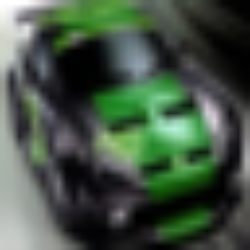

In [24]:
# Get a random training images
random_img_idx = torch.randint(0, 1000, (1,)).item()


test_image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
print('The size of image variable is Channel, Height, Width ',test_image.shape)

test_image = resize(test_image, (250, 250), antialias=None)  # better visualization
print('Number of channels in test_image: ', test_image.shape[0])
to_pil_image(test_image)

## Step 2: Define a Simple Neural Network
We'll start by defining a simple feedforward neural network with one hidden layer.

`nn.Linear` module automatically creates a linear transformation with bias and weight tensors that can be used in the forward feed. You can access these using model.hidden.weight or model.hidden.bias.


Remember the size of an image in CIFAR is 3x32x32. Based on that think carefuly about what the input dimension of your first layer should be.

Remember the total number of unique classes (images) in CIFAR is 10. Based on that think carefuly about what the output dimension of your last layer should be.



In [25]:
class SimpleNN(nn.Module):
    """
    A simple Multi-Layer Perceptron (MLP) model for image classification using fully connected layers.

    This neural network has three layers:
      - Input Layer (fc1): Takes a flattened input image and maps it to 128 neurons.
      - Hidden Layer (fc2): Maps the output of the first layer to 64 neurons.
      - Output Layer (fc3): Maps the 64 neurons to 10 output neurons.

    Parameters:
    -----------
    activation_function : nn.Module
        The activation function to be applied after each fully connected layer (e.g., ReLU, Sigmoid, Tanh).

    Methods:
    --------
    forward(x):
        Defines the forward pass of the network. Applies the activation function after each layer, except the final layer.

    Example:
    --------
    model = SimpleNN(activation_function=nn.ReLU())
    output = model(input_image)

    Notes:
    ------
    - `x.view(-1, 3*32*32)` reshapes the input images from (batch_size, 3,32,32) to (batch_size, 3072) for the fully connected layer.
    - Each activation function transforms layer outputs, introducing non-linearity and enabling the network to learn complex patterns.
    """

    def __init__(self, activation_function):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 128)  # Input layer: Flatten 28x28 to 784 and map to 128
        self.fc2 = nn.Linear(128, 64)     # Hidden layer: Map 128 to 64
        self.fc3 = nn.Linear(64, 10)      # Output layer: Map 64 to 10

        # Store the activation function
        self.activation_function = activation_function

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(-1, 3*32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.fc3(x)
        return x
SimpleNN(nn.ReLU())

SimpleNN(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (activation_function): ReLU()
)

## Define Training and Evaluation Functions
Let's define the evaluation functions first because it's easy and will be called in training function later.
We will define these function such that they return Accuracy which we can plot later on. Ideally you should plot both loss and accuracy per epoch and keep a close eye on both.

- CAUTION: In this notebook, the evaluation phase is using test_loader directly in evaluate_model just to make things simpler. In real life, if test_loader represents your final test dataset, this should not be used during training at all.
Instead, a separate validation set split from the training data should be used for the validation phase during training. This avoids data leakage into the final evaluation.
    

In [26]:
# Evaluation function
def evaluate_model(model, criterion, test_loader,device):
    """
    Evaluates the performance of a trained neural network model on a validation dataset.

    This function computes the accuracy of the model by comparing its predictions to the actual labels
    in the validation set. The accuracy metric is printed as a percentage of correctly classified samples.

    Parameters:
    -----------
    model : nn.Module
        The trained neural network model to be evaluated.
    criterion : nn.Module
        Loss function to use (e.g., CrossEntropyLoss).
    test_loader : DataLoader
        DataLoader for the validation set.

    Returns:
    --------
    val_loss : float
        Average validation loss over the dataset.
    val_accuracy : float
        Validation accuracy as a percentage.

    Process:
    --------
    - model.eval() Sets the model to evaluation mode ensuring that dropout and batch normalization behave properly during evaluation
    - Disables gradient computation with `torch.no_grad()` to speed up evaluation and save memory.
    - Iterates over each batch in the test DataLoader (`test_loader`):
        1. Passes each batch of images through the model to obtain predictions.
        2. Uses `torch.max` to find the predicted class label with the highest score.
        3. Compares the predicted labels to the actual labels and counts correct predictions.
    - Calculates accuracy as the percentage of correct predictions out of the total samples.

    Notes:
    ------
    - `torch.no_grad()` is used to reduce memory usage and computation, as gradients are not needed during evaluation.
    - `torch.max(outputs.data, 1)` retrieves the predicted class with the highest probability for each sample in the batch.
    - `correct / total * 100` gives the model's accuracy as a percentage, which is a commonly used metric for classification tasks.

    Example:
    --------
    evaluate_model(model)

    This will output the accuracy and loss of the model on the validation set, for example:
    """
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute validation loss
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation metrics
    val_loss = val_running_loss / len(test_loader)
    val_accuracy = 100 * val_correct / val_total
    return val_loss, val_accuracy


In [27]:
# Training function
def train_model(model,criterion, optimizer, train_loader, test_loader,device, epochs=5):
    """
    Trains a neural network model using the specified loss function and optimizer.

    This function performs a forward pass, computes the loss, and applies backpropagation
    to update the model's weights for each epoch. The running loss for each epoch is calculated
    and displayed to track the training progress.

    Parameters:
    -----------
    model : nn.Module
        The neural network model to be trained.

    criterion : nn.Module
        The loss function used to measure how far the model's predictions are from the target labels.
        Common choices include CrossEntropyLoss for classification or MSELoss for regression.

    optimizer : torch.optim.Optimizer
        The optimization algorithm used to update model parameters based on gradients. Examples include
        SGD (Stochastic Gradient Descent) and Adam.

     train_loader : DataLoader
        DataLoader for the training set.

    val_loader : DataLoader
        DataLoader for the validation set.

    epochs : int, optional (default=5)
        The number of full passes through the training dataset.

    Returns:
    --------
    train_accuracies : list of floats
        Training accuracy for each epoch.

    val_accuracies : list of floats
        Validation accuracy for each epoch.

    Process:
    --------
    - For each epoch, reset the running loss.
    - For each mini-batch:
        1. Perform a forward pass to compute the model's predictions.
        2. Calculate the loss by comparing predictions with actual labels.
        3. Perform backpropagation to compute gradients.
        4. Use the optimizer to update the model's weights.
        5. Accumulate the batch loss into running_loss.
    - After each epoch, compute and print the average loss and accuracies.

    Notes:
    ------
    - `optimizer.zero_grad()` clears old gradients to prevent accumulation from previous batches.
    - `loss.backward()` computes gradients based on the current batch loss.
    - `optimizer.step()` updates the model's weights using the computed gradients.
    - `running_loss / len(train_loader)` provides the average loss per batch in each epoch,
      giving insight into how well the model is learning over time.


    Example:
    --------
    train_model(model, criterion=nn.CrossEntropyLoss(), optimizer=torch.optim.SGD(model.parameters(), lr=0.01), epochs=10)
    """
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients


            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate batch loss
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)  # Increment total samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

        # Calculate epoch training accuracy
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)
        # Validation phase (call separate function)
        val_loss, val_accuracy = evaluate_model(model, criterion,test_loader,device) #CAUTION: See note above
        val_accuracies.append(val_accuracy)

        # Print progress
        print(
            f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%"
        )

    return train_accuracies, val_accuracies

## Step 3: Experimenting with Activation Functions
We'll test our network with different activation functions: ReLU, Sigmoid, and Tanh.

### Instructions
1. Instantiate the model with each activation function.
2. Train and evaluate the model with each activation function.
3. Observe and record your findings.


In [28]:
num_epochs = 15
learning_rate = 0.001
print(f'Using device {device}')


Using device cuda



Testing with activation function: ReLU()
Epoch [1/15], Train Loss: 2.2967, Train Accuracy: 14.74%, Val Loss: 2.2871, Val Accuracy: 17.74%
Epoch [2/15], Train Loss: 2.2788, Train Accuracy: 16.46%, Val Loss: 2.2701, Val Accuracy: 15.77%
Epoch [3/15], Train Loss: 2.2607, Train Accuracy: 16.67%, Val Loss: 2.2505, Val Accuracy: 17.23%
Epoch [4/15], Train Loss: 2.2390, Train Accuracy: 17.67%, Val Loss: 2.2265, Val Accuracy: 17.91%
Epoch [5/15], Train Loss: 2.2125, Train Accuracy: 18.88%, Val Loss: 2.1978, Val Accuracy: 19.59%
Epoch [6/15], Train Loss: 2.1816, Train Accuracy: 20.24%, Val Loss: 2.1652, Val Accuracy: 22.15%
Epoch [7/15], Train Loss: 2.1487, Train Accuracy: 22.38%, Val Loss: 2.1324, Val Accuracy: 24.44%
Epoch [8/15], Train Loss: 2.1172, Train Accuracy: 24.62%, Val Loss: 2.1026, Val Accuracy: 25.91%
Epoch [9/15], Train Loss: 2.0894, Train Accuracy: 26.34%, Val Loss: 2.0766, Val Accuracy: 27.30%
Epoch [10/15], Train Loss: 2.0654, Train Accuracy: 27.49%, Val Loss: 2.0541, Val Accu

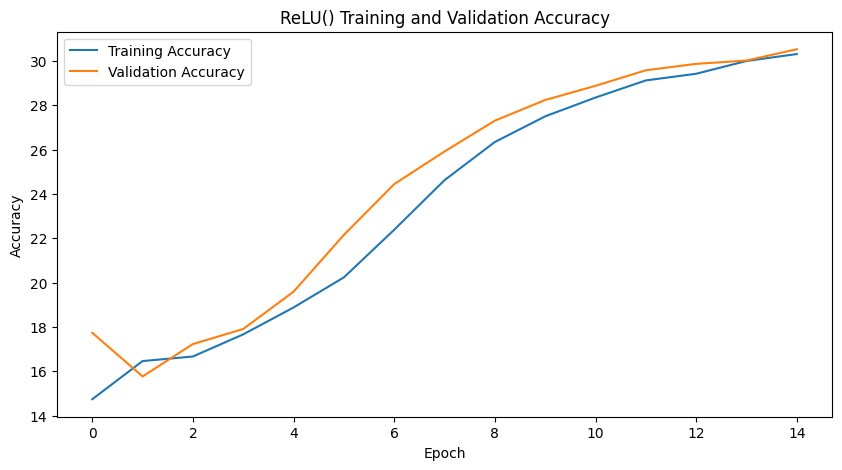


Testing with activation function: Sigmoid()
Epoch [1/15], Train Loss: 2.3167, Train Accuracy: 10.00%, Val Loss: 2.3076, Val Accuracy: 10.00%
Epoch [2/15], Train Loss: 2.3049, Train Accuracy: 10.00%, Val Loss: 2.3032, Val Accuracy: 10.00%
Epoch [3/15], Train Loss: 2.3027, Train Accuracy: 10.00%, Val Loss: 2.3023, Val Accuracy: 10.08%
Epoch [4/15], Train Loss: 2.3021, Train Accuracy: 11.30%, Val Loss: 2.3019, Val Accuracy: 16.04%
Epoch [5/15], Train Loss: 2.3018, Train Accuracy: 13.76%, Val Loss: 2.3016, Val Accuracy: 14.08%
Epoch [6/15], Train Loss: 2.3015, Train Accuracy: 14.34%, Val Loss: 2.3013, Val Accuracy: 13.51%
Epoch [7/15], Train Loss: 2.3012, Train Accuracy: 14.59%, Val Loss: 2.3010, Val Accuracy: 15.90%
Epoch [8/15], Train Loss: 2.3009, Train Accuracy: 14.87%, Val Loss: 2.3007, Val Accuracy: 17.44%
Epoch [9/15], Train Loss: 2.3007, Train Accuracy: 15.26%, Val Loss: 2.3005, Val Accuracy: 17.47%
Epoch [10/15], Train Loss: 2.3004, Train Accuracy: 15.90%, Val Loss: 2.3002, Val A

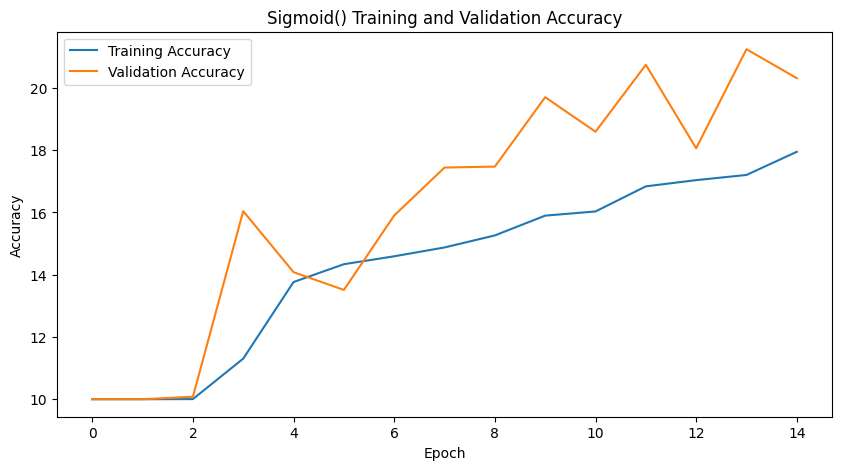


Testing with activation function: Tanh()
Epoch [1/15], Train Loss: 2.2816, Train Accuracy: 15.57%, Val Loss: 2.2605, Val Accuracy: 16.32%
Epoch [2/15], Train Loss: 2.2416, Train Accuracy: 21.51%, Val Loss: 2.2219, Val Accuracy: 25.18%
Epoch [3/15], Train Loss: 2.2022, Train Accuracy: 25.39%, Val Loss: 2.1825, Val Accuracy: 26.81%
Epoch [4/15], Train Loss: 2.1630, Train Accuracy: 26.90%, Val Loss: 2.1440, Val Accuracy: 27.96%
Epoch [5/15], Train Loss: 2.1261, Train Accuracy: 28.03%, Val Loss: 2.1092, Val Accuracy: 28.95%
Epoch [6/15], Train Loss: 2.0932, Train Accuracy: 28.78%, Val Loss: 2.0782, Val Accuracy: 29.76%
Epoch [7/15], Train Loss: 2.0647, Train Accuracy: 29.37%, Val Loss: 2.0518, Val Accuracy: 30.36%
Epoch [8/15], Train Loss: 2.0402, Train Accuracy: 29.71%, Val Loss: 2.0291, Val Accuracy: 30.63%
Epoch [9/15], Train Loss: 2.0190, Train Accuracy: 30.06%, Val Loss: 2.0094, Val Accuracy: 30.79%
Epoch [10/15], Train Loss: 2.0005, Train Accuracy: 30.50%, Val Loss: 1.9922, Val Accu

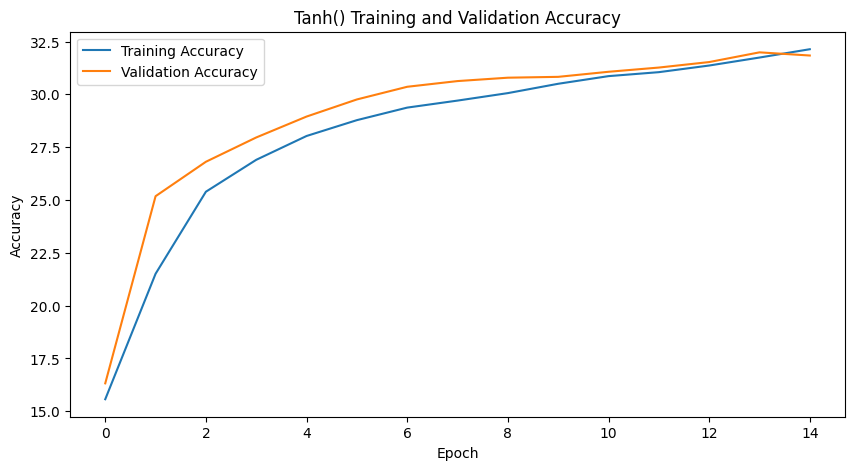

In [29]:
# List of activation functions to test
activations = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
criterion = nn.CrossEntropyLoss()

for activation in activations:
    print(f"\nTesting with activation function: {activation}")
    model = SimpleNN(activation)
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Start timer
    start_time = time.time()

    # Train the model
    train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, device,epochs=num_epochs)

    # Calculate elapsed time
    end_time = time.time()
    total_time = end_time - start_time

    # Print total time and accuracy
    print(f"Total time taken: {total_time:.2f} seconds")

        # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('{} Training and Validation Accuracy'.format(activation))
    plt.show()

#### Two take-aways from the above:
1. ReLU and TanH perform much better in capturing the underlying complexity of data compared to Sigmoid.
2. We could let the models run for longer epochs (since the loss is decreasing) but it is clear that a linear model is too simple to fit our training data. Our accuracy is very low and this is a clear case of underfitting. Time to try a more complex model. Let's explore the power of Convolution Neural Networks to classify CIFAR.



### Evaluating model fit
- **Underfitting**: Both training and validation losses are high and accuracy low, indicating that the model is not learning enough patterns from the data.
- **Good Fit**: Training and validation losses are both low and stable.
- **Overfitting**: Training loss continues to decrease, but validation loss does not improve or begins to increase, suggesting the model is memorizing the training data and is not generalizable.


## Step 4: Implementing CNN
We shall use ReLU as our activation function and Adam as our optimizer.

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First Convolutional Block
        # Input: 3 channels (RGB), Output: 64 channels
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()


         # Second Convolutional Block
        # Input: 64 channels, Output: 128 channels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Third Convolutional Block
        # Input: 128 channels, Output: 256 channels
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        # Reduces spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        # First fully connected layer
        # Input: Flattened feature maps (256 * 8 * 8), Output: 512 neurons
        self.flatten = nn.Flatten()  # Flatten layer for linear layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # Flattened size after pooling
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)  # Output size: 10 (CIFAR-10 classes)

    def forward(self, x):
        # Convolutional and pooling layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        # Flatten the tensor for the fully connected layers
        x = self.flatten(x)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
SimpleCNN()

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [33]:
num_epochs = 25
learning_rate = 0.001

model = SimpleCNN().to(device)# send model to gpu
print(f'Using device {device}')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Using device cuda


Epoch [1/25], Train Loss: 1.4056, Train Accuracy: 48.88%, Val Loss: 1.0491, Val Accuracy: 62.80%
Epoch [2/25], Train Loss: 0.8744, Train Accuracy: 69.40%, Val Loss: 0.8107, Val Accuracy: 71.78%
Epoch [3/25], Train Loss: 0.6372, Train Accuracy: 77.66%, Val Loss: 0.7438, Val Accuracy: 74.68%
Epoch [4/25], Train Loss: 0.4490, Train Accuracy: 84.37%, Val Loss: 0.7841, Val Accuracy: 75.32%
Epoch [5/25], Train Loss: 0.2859, Train Accuracy: 90.01%, Val Loss: 0.8243, Val Accuracy: 75.26%
Epoch [6/25], Train Loss: 0.1666, Train Accuracy: 94.16%, Val Loss: 1.0064, Val Accuracy: 76.05%
Epoch [7/25], Train Loss: 0.1103, Train Accuracy: 96.25%, Val Loss: 1.1159, Val Accuracy: 74.85%
Epoch [8/25], Train Loss: 0.0868, Train Accuracy: 97.06%, Val Loss: 1.3419, Val Accuracy: 75.42%
Epoch [9/25], Train Loss: 0.0688, Train Accuracy: 97.70%, Val Loss: 1.2418, Val Accuracy: 74.91%
Epoch [10/25], Train Loss: 0.0676, Train Accuracy: 97.80%, Val Loss: 1.4777, Val Accuracy: 74.77%
Epoch [11/25], Train Loss: 0.

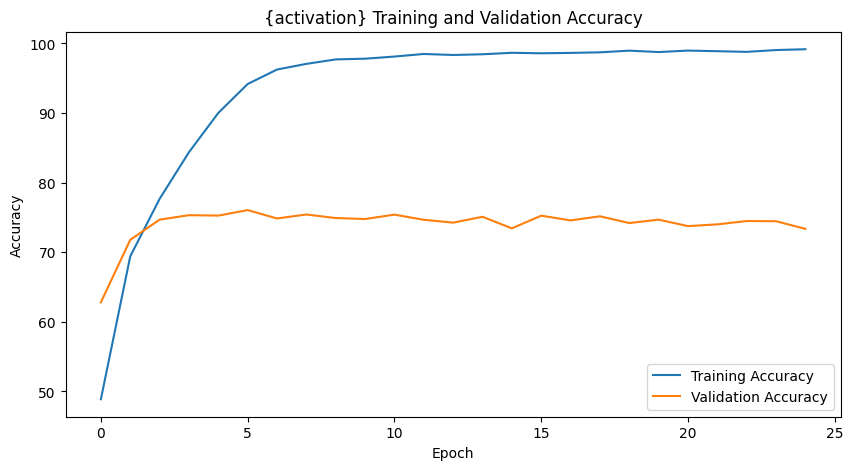

In [34]:

# Start timer
start_time = time.time()

# Train the model
train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, device,epochs=num_epochs)

# Calculate elapsed time
end_time = time.time()
total_time = end_time - start_time

# Print total time and accuracy
print(f"Total time taken: {total_time:.2f} seconds")

    # Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('{activation} Training and Validation Accuracy')
plt.show()

We've overcorrected!!
Now, our model is a classic case of overfitting.
Let's add some regularization to keep training in check.


Btw, try switching Adam with SGD for the above block and see what happens ;)

## Step 5: Implementing Regularization

To prevent overfitting, implement the following:
- Apply Dropout after every fully connected (linear) layer (except the output layer)
- Apply Batch Normalization after every convolution layer.
- Apply L2 regularization (weight decay) to optimizer



In [44]:
class RegularizedCNN(nn.Module):
    """

    This model includes convolutional layers with Batch Normalization, ReLU activation, and MaxPooling,
    followed by fully connected layers with Dropout for regularization.

    Architecture:
    1. Three convolutional layers:
        - Convolution + Batch Normalization + ReLU
        - MaxPooling applied after the 2nd and 3rd convolutional layers
    2. Fully connected layers:
        - Includes Dropout
        - Outputs logits for 10 classes (e.g., CIFAR-10 classification)

    Methods:
    --------
    forward(x):
        Defines the forward pass through the network, applying the activation function, dropout, batch norm ,
        and fully connected layers. The output layer has no activation function applied.


    Notes:
    ------
    - Dropout is used as a regularization technique to reduce overfitting by randomly deactivating neurons during training..
    - No activation function is applied to the output layer, allowing it to output raw scores, which are used with a
      CrossEntropyLoss criterion.
    """

    def __init__(self):
        super(RegularizedCNN, self).__init__()

        # First Convolutional Block
        # Input: 3 channels (RGB), Output: 64 channels
        # BatchNorm normalizes the activations for stability
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()


         # Second Convolutional Block
        # Input: 64 channels, Output: 128 channels
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Third Convolutional Block
        # Input: 128 channels, Output: 256 channels
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

        # Pooling layer
        # Reduces spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Flatten layer prepares feature maps for the linear layers
        self.flatten = nn.Flatten()

        # First fully connected layer
        # Input: Flattened feature maps (256 * 8 * 8), Output: 512 neurons
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional and pooling layers with BatchNorm
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        # Flatten for fully connected layers
        x = self.flatten(x)

        # Fully connected layers with BatchNorm and Dropout
        x = self.dropout(self.relu((self.fc1(x))))
        x = self.dropout(self.relu((self.fc2(x))))
        x = self.fc3(x)

        return x

RegularizedCNN()

RegularizedCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [45]:
num_epochs = 40
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

model = RegularizedCNN().to(device)# send model to gpu
print(f'Using device {device}')

optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)


Using device cuda


Epoch [1/40], Train Loss: 1.7661, Train Accuracy: 35.22%, Val Loss: 1.4922, Val Accuracy: 49.11%
Epoch [2/40], Train Loss: 1.3130, Train Accuracy: 53.03%, Val Loss: 1.1420, Val Accuracy: 61.13%
Epoch [3/40], Train Loss: 1.1481, Train Accuracy: 59.53%, Val Loss: 1.0746, Val Accuracy: 65.62%
Epoch [4/40], Train Loss: 1.0465, Train Accuracy: 63.89%, Val Loss: 0.9798, Val Accuracy: 70.44%
Epoch [5/40], Train Loss: 0.9609, Train Accuracy: 66.98%, Val Loss: 0.9734, Val Accuracy: 68.61%
Epoch [6/40], Train Loss: 0.8994, Train Accuracy: 69.28%, Val Loss: 0.8931, Val Accuracy: 72.48%
Epoch [7/40], Train Loss: 0.8409, Train Accuracy: 70.83%, Val Loss: 0.8262, Val Accuracy: 74.36%
Epoch [8/40], Train Loss: 0.7975, Train Accuracy: 72.58%, Val Loss: 0.7790, Val Accuracy: 76.00%
Epoch [9/40], Train Loss: 0.7440, Train Accuracy: 74.35%, Val Loss: 0.7909, Val Accuracy: 74.20%
Epoch [10/40], Train Loss: 0.6968, Train Accuracy: 75.89%, Val Loss: 0.7127, Val Accuracy: 78.04%
Epoch [11/40], Train Loss: 0.

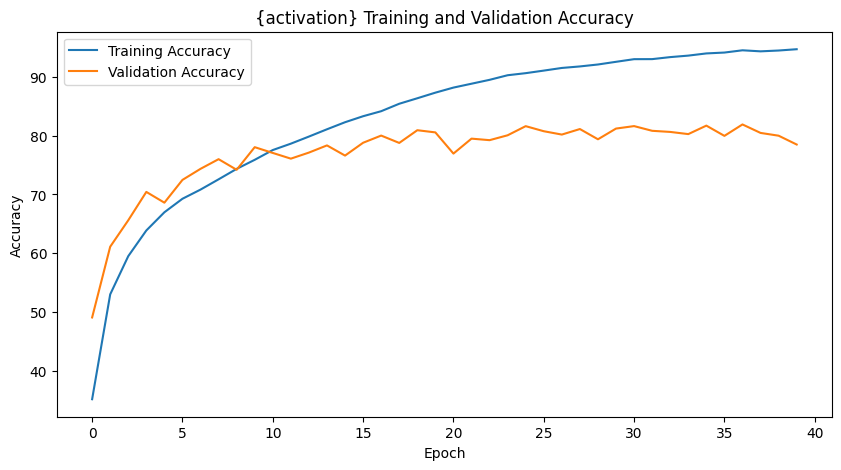

In [46]:
# Start timer
start_time = time.time()

# Train the model
train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, device,epochs=num_epochs)

# Calculate elapsed time
end_time = time.time()
total_time = end_time - start_time

# Print total time and accuracy
print(f"Total time taken: {total_time:.2f} seconds")

    # Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('{activation} Training and Validation Accuracy')
plt.show()

Okay, much better but still not quite there.
While regularization has helped us achieve a better learning curve and increased our ability to predict the test dataset more accuractely (from 74% to 80%), the model is still leaning towards overfitting. Ideally, we should have stopped training around 20th epoch when we stopped seeing gains in validation accuracy.

So how can we know which epoch to stop training on before we ever run a model? Mind you, that epoch number would be different for differnt learning rates and model parameters.

Before moving to the next section, think for a moment some logic you can code to help us stop training before the model starts overfitting...


Btw, there are many more ways of aiding model training e.g. Data Augmentation, Image Transformation and Normalization, Transfer Learning, Residual Layer etc. which we will cover in the Deep Image Learning module.

## Step 6: Early Stopping and Model Checkpointing

**Early Stopping** Stops training if the validation accuracy does not improve for a specified number of consecutive epochs (patience). It is controlled by a counter (epochs_without_improvement).


**Model Checkpointing**
allows you to save the model’s state whenever it achieves the best performance on the validation set. Uses torch.save() to store the model’s state dictionary to the provided checkpoint_path. Keeps track of the best validation accuracy achieved during training (best_val_accuracy)


**Advantages**
Prevents wasting time on unnecessary epochs once the model stops improving.
Prevents overfitting by breaking off training when dimishing returns on val accuracy.
Checkpointing automatically saves the best model, ensuring you don’t lose progress if training stops early or you lose server connection.



For more advance implementation, check out Pytorch's Early stopping function: https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html

In [38]:
def train_model_with_early_stopping(
    model, train_loader, test_loader, criterion, optimizer, device, epochs, patience, checkpoint_path
):
    """
    Train a model with early stopping and model checkpointing.

    Args:
    - model: The PyTorch model to train.
    - train_loader: DataLoader for the training set.
    - test_loader: DataLoader for the validation/test set.
    - criterion: Loss function.
    - optimizer: Optimizer for the model.
    - device: 'cpu' or 'cuda'.
    - epochs: Number of epochs to train.
    - patience: Number of epochs to wait for improvement before stopping.
    - checkpoint_path: Path to save the best model.

    Returns:
    - train_accuracies: List of training accuracies per epoch.
    - val_accuracies: List of validation accuracies per epoch.
    """

    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Clear previous gradients

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()  # Accumulate batch loss
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)  # Increment total samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

        # Calculate epoch training accuracy
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        val_loss, val_accuracy = evaluate_model(model, criterion, test_loader, device)
        val_accuracies.append(val_accuracy)

        # Save the model if validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0  # Reset the patience counter
            # Save model checkpoint
            print(f"Validation accuracy improved to {val_accuracy:.2f}%. Saving model...")
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_without_improvement += 1

        # Early stopping check
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # Print progress
        print(
            f"Epoch [{epoch+1}/{epochs}], "
            f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%"
        )

    print(f"Training completed. Best validation accuracy: {best_val_accuracy:.2f}%.")
    return train_accuracies, val_accuracies


In [48]:
num_epochs = 50
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

model = RegularizedCNN().to(device)# send model to gpu
print(f'Using device {device}')
patience = 3
checkpoint_path = "best_model.pth"

optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)


Using device cuda


In [49]:
# Start timer
start_time = time.time()

# Train the model
train_accuracies, val_accuracies = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=num_epochs,
    patience=patience,
    checkpoint_path=checkpoint_path,
)
# Calculate elapsed time
end_time = time.time()
total_time = end_time - start_time

# Print total time and accuracy
print(f"Total time taken: {total_time:.2f} seconds")


Validation accuracy improved to 54.52%. Saving model...
Epoch [1/50], Train Loss: 1.7182, Train Accuracy: 37.37%, Val Loss: 1.3090, Val Accuracy: 54.52%
Validation accuracy improved to 61.48%. Saving model...
Epoch [2/50], Train Loss: 1.2862, Train Accuracy: 54.01%, Val Loss: 1.1332, Val Accuracy: 61.48%
Validation accuracy improved to 65.28%. Saving model...
Epoch [3/50], Train Loss: 1.1214, Train Accuracy: 60.80%, Val Loss: 1.0537, Val Accuracy: 65.28%
Validation accuracy improved to 67.93%. Saving model...
Epoch [4/50], Train Loss: 1.0238, Train Accuracy: 64.54%, Val Loss: 0.9721, Val Accuracy: 67.93%
Validation accuracy improved to 70.03%. Saving model...
Epoch [5/50], Train Loss: 0.9365, Train Accuracy: 67.75%, Val Loss: 0.9376, Val Accuracy: 70.03%
Epoch [6/50], Train Loss: 0.8808, Train Accuracy: 69.73%, Val Loss: 0.9121, Val Accuracy: 68.53%
Validation accuracy improved to 70.63%. Saving model...
Epoch [7/50], Train Loss: 0.8091, Train Accuracy: 72.28%, Val Loss: 0.8843, Val Ac

## Summary and Analysis
Reflect on your findings:
1. Which activation function performed best? Why do you think that is?
2. How did dropout and L2 regularization impact overfitting?

### Key Takeaways
This practical has shown you how to train nueral networks and how core components like activation functions, regularization, and optimization techniques affect a neural network's performance.
